In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr

In [2]:
# Check the Data structure & analysis
sample_file = os.listdir('dataset/train')[0]
df = pd.read_csv(f'dataset/train/{sample_file}')

# Show shape and head
print(f"Shape: {df.shape}")
display(df.head())

# List columns
print("Columns:", df.columns.tolist())

Shape: (132001, 59)


,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,0.000,509.630351,609.688545,522.032153,454.102593,309.486489,524.804335,484.333383,587.340998,469.651564,...,295.834834,485.530586,411.161892,448.726097,99.151239,613.529369,428.286969,378.933590,-906.668876,0
1,0.005,864.521388,1038.483761,917.023604,775.970207,576.123392,934.962455,833.427809,996.070640,823.715523,...,528.713692,894.541770,735.827300,780.487458,239.407648,1067.349342,782.319229,711.286079,-1484.107119,0
2,0.010,754.576625,904.117869,803.235608,678.039830,489.573235,803.064230,706.392172,868.996293,717.565698,...,459.066586,870.217213,691.971456,689.656321,255.876323,933.617965,679.366071,699.014004,-1313.435186,0
3,0.015,801.593761,957.870867,834.026569,716.254450,519.006819,860.058239,769.518284,921.777695,756.664761,...,487.899954,905.564172,723.595463,723.944898,247.990115,992.180045,713.405603,714.734949,-1391.966973,0
4,0.020,769.054899,920.060832,811.596932,692.750986,494.315305,817.206918,727.500302,892.004312,729.239924,...,464.032652,769.258159,642.962959,687.852792,179.835749,949.832471,680.906506,607.057329,-1347.494166,0


Columns: ['Time', 'Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'POz', 'P08', 'O1', 'O2', 'EOG', 'FeedBackEvent']


In [3]:
data_path = 'dataset/train'
label_path = 'dataset/TrainLabels.csv'

# List of EEG session files
session_files = sorted(os.listdir(data_path))
print(f"Total EEG sessions: {len(session_files)}")

# Load labels
labels_df = pd.read_csv(label_path)
print(labels_df.head())
print(f"Total labels: {labels_df.shape[0]}")

Total EEG sessions: 80
         IdFeedBack  Prediction
0  S02_Sess01_FB001           1
1  S02_Sess01_FB002           1
2  S02_Sess01_FB003           0
3  S02_Sess01_FB004           0
4  S02_Sess01_FB005           1
Total labels: 5440


In [4]:
sample_file = pd.read_csv(os.path.join(data_path, session_files[0]))
print("Sample EEG session shape:", sample_file.shape)

Sample EEG session shape: (132001, 59)


### Check if dataset is Balanced or Not

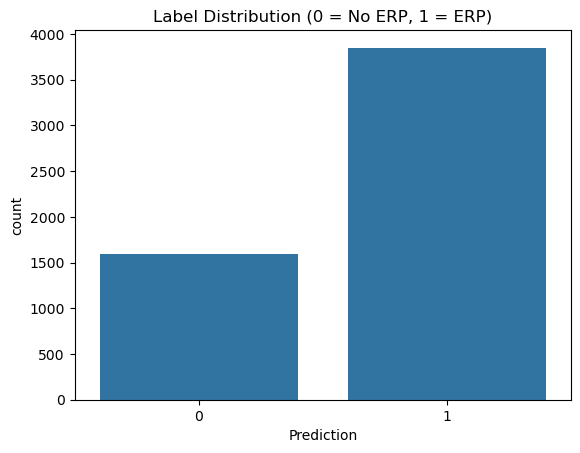

In [61]:
sns.countplot(x='Prediction', data=labels_df)
plt.title('Label Distribution (0 = No ERP, 1 = ERP)')
plt.show()


### Preprocessing

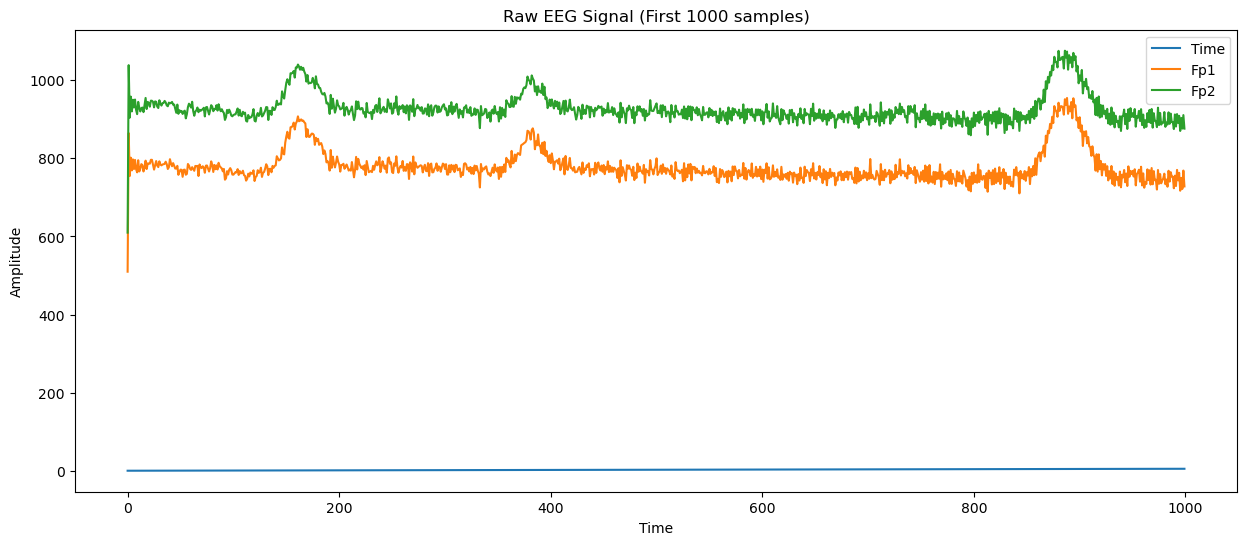

In [5]:
# Visualize more closely
eeg_channels = [col for col in df.columns if col not in ['FeedBackEvent', 'EOG']]

# Plot a few EEG channels
plt.figure(figsize=(15, 6))
for ch in eeg_channels[:3]:
    plt.plot(df[ch].values[:1000], label=ch)  # first 1000 samples
plt.title('Raw EEG Signal (First 1000 samples)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

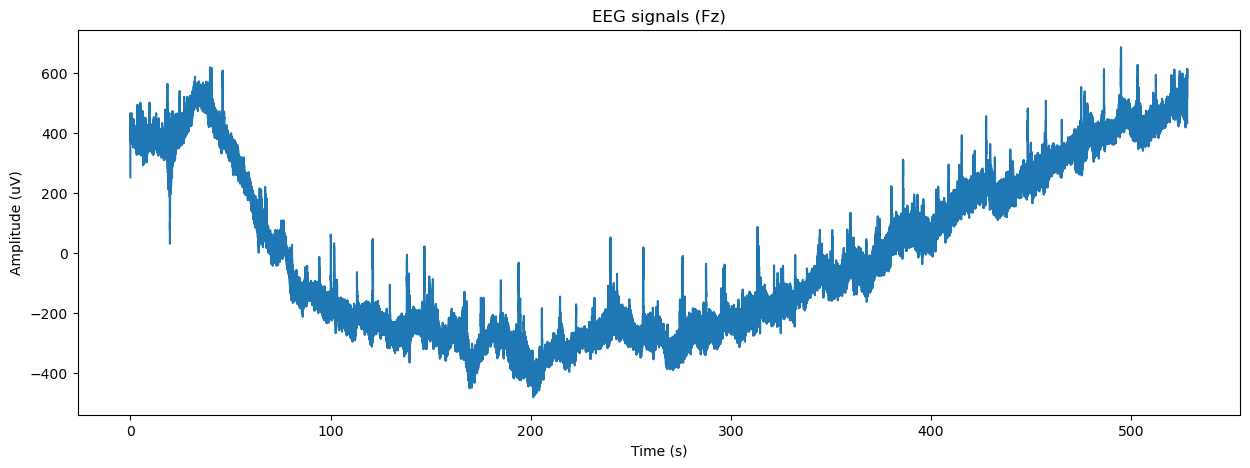

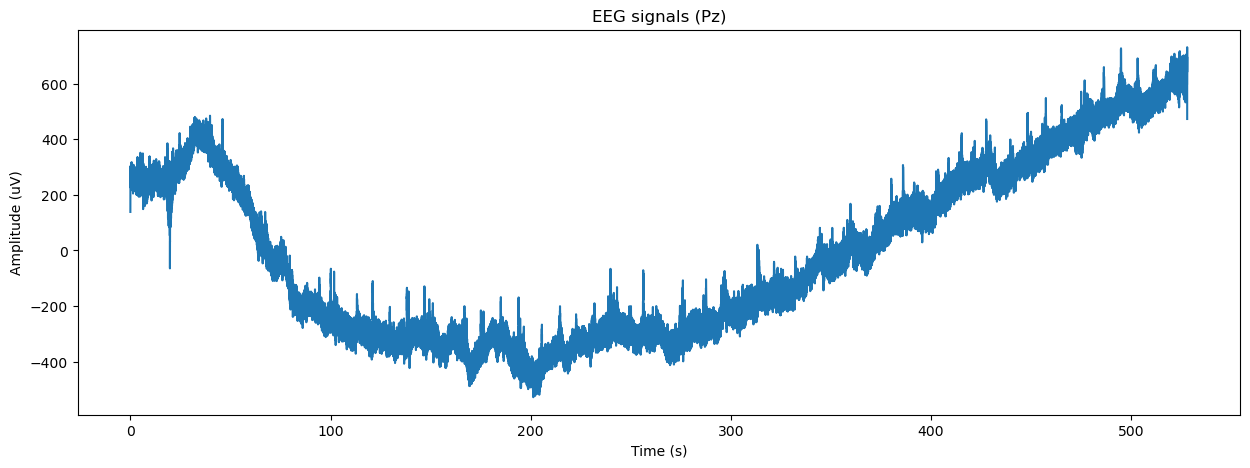

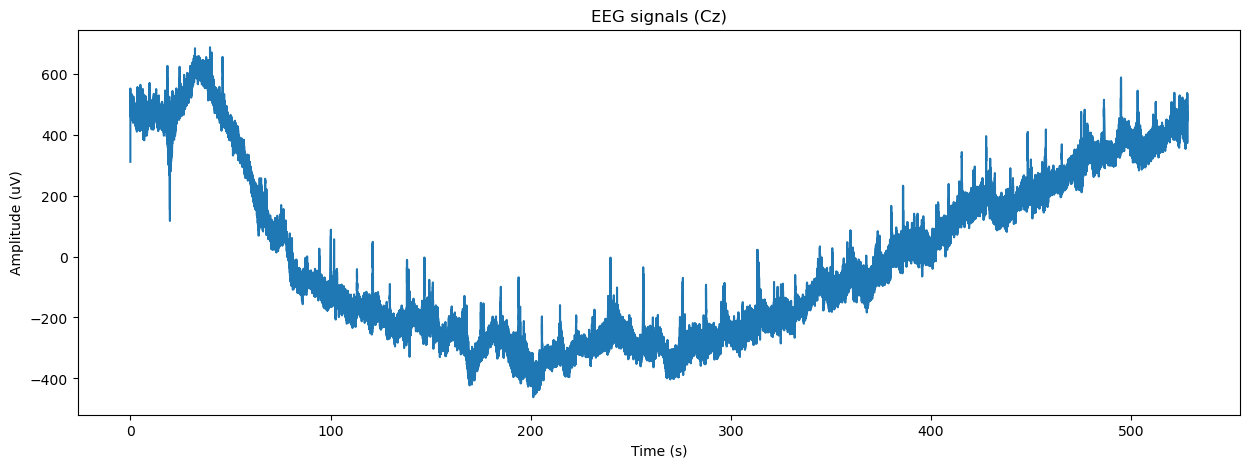

In [6]:
sampling_rate = 250  # Hz
num_samples = len(sample_file['Fz'])
time_axis = np.arange(num_samples) / sampling_rate  # in seconds

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Fz'])
plt.title('EEG signals (Fz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Pz'])
plt.title('EEG signals (Pz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(time_axis, sample_file['Cz'])
plt.title('EEG signals (Cz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.show()

In [7]:
def filter(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

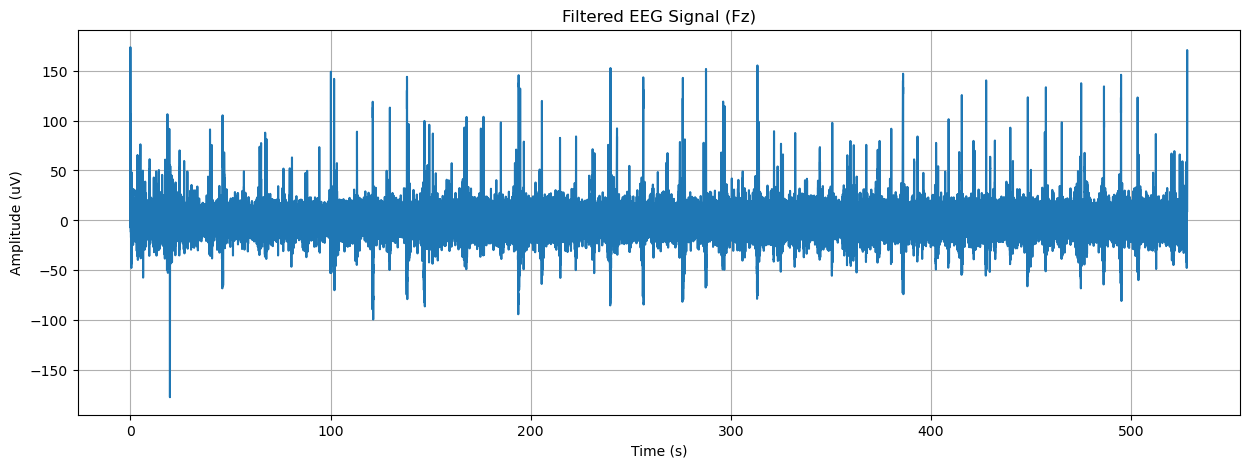

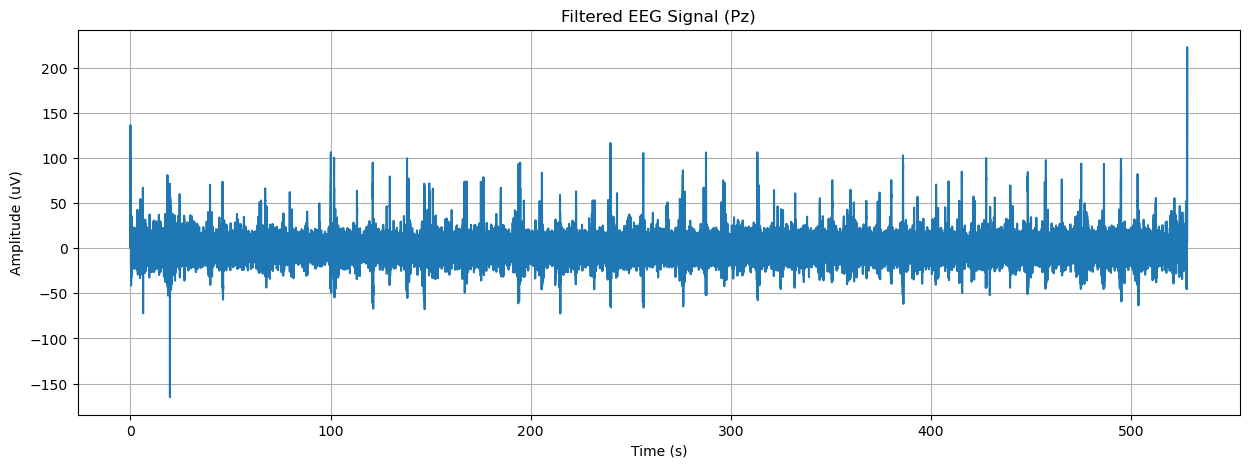

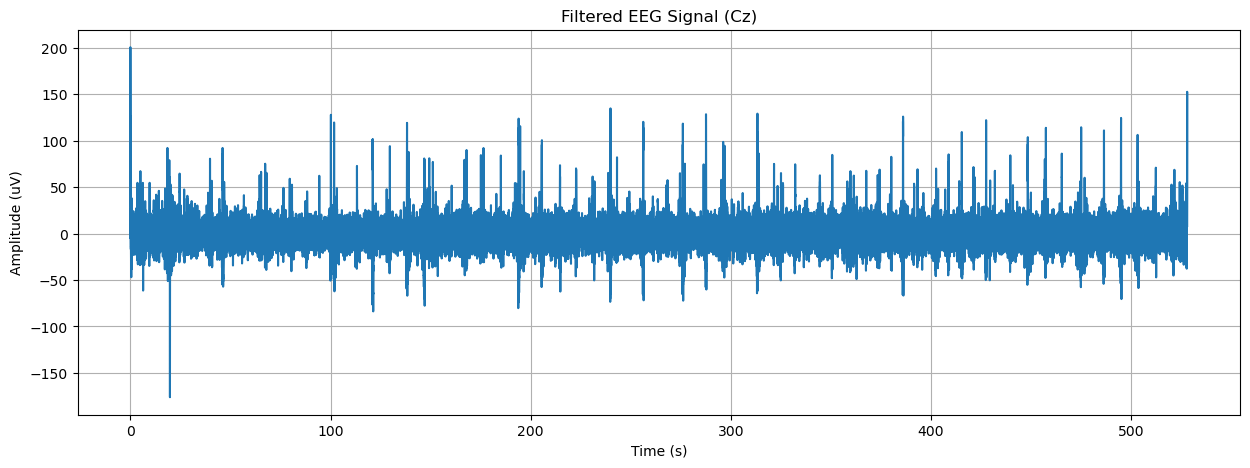

In [8]:
# Create time axis
sampling_rate = 250  # Hz
num_samples = len(sample_file['Fz'])

# Plot for Fz
filtered_fz = filter(sample_file['Fz'].values)

plt.figure(figsize=(15, 5))
plt.plot(time_axis, filtered_fz)
plt.title('Filtered EEG Signal (Fz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.grid(True)
plt.show()

# Plot for Pz
filtered_pz = filter(sample_file['Pz'].values)

plt.figure(figsize=(15, 5))
plt.plot(time_axis, filtered_pz)
plt.title('Filtered EEG Signal (Pz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.grid(True)
plt.show()

# Plot for Cz
filtered_cz = filter(sample_file['Cz'].values)

plt.figure(figsize=(15, 5))
plt.plot(time_axis, filtered_cz)
plt.title('Filtered EEG Signal (Cz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.grid(True)
plt.show()

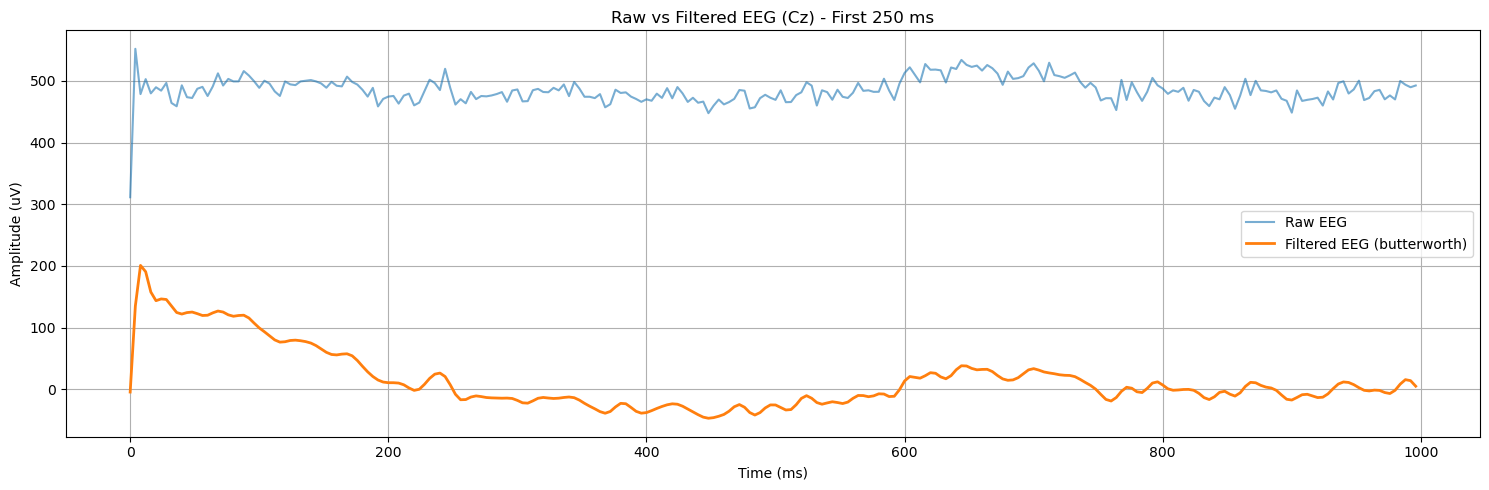

In [60]:
# Duration to plot (in seconds)
plot_duration_sec = 1  # 250 ms
num_plot_samples = int(plot_duration_sec * sampling_rate)

# Extract samples
raw_cz = sample_file['Cz'].values[:num_plot_samples]
filtered_cz_segment = filtered_cz[:num_plot_samples]
time_segment = time_axis[:num_plot_samples] * 1000  # convert to ms

# Plot raw vs filtered
plt.figure(figsize=(15, 5))
plt.plot(time_segment, raw_cz, label='Raw EEG', alpha=0.6)
plt.plot(time_segment, filtered_cz_segment, label='Filtered EEG (butterworth)', linewidth=2)
plt.title('Raw vs Filtered EEG (Cz) - First 250 ms')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']
len(eeg_channels)

56

In [16]:
all_raw_epochs = []
all_labels = pd.read_csv('dataset/TrainLabels.csv').Prediction.values

for filename in tqdm(os.listdir('dataset/train')):  # Loop through all sessions
    session_data = pd.read_csv('dataset/train/' + filename)  # Load one session
    
    # Identify feedback events (assuming "FeedBackEvent" is the column with event markers)
    session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index
    
    session_epochs = []  # List to store all epochs in the session
    
    for idx in session_feedback_ids:
        # Extract the epoch: 200ms before (40 samples at 250Hz) and 1000ms after (200 samples at 250Hz)
        epoch = session_data.loc[idx - 40: idx + 199]
        
        # Perform baseline correction: calculate baseline over 200ms before the event
        baseline = epoch.loc[idx - 40: idx, eeg_channels].values.mean(axis=0)  # Mean of channels before the event
        epoch.loc[:, eeg_channels] -= baseline  # Baseline correction by subtracting the mean
        
        # Append the baseline-corrected epoch to the session's epochs list
        session_epochs.append(epoch[eeg_channels].values)
    
    # Add the epochs of the current session to the global list
    all_raw_epochs.extend(session_epochs)

print(f"Total number of epochs collected: {len(all_raw_epochs)}")

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [03:55<00:00,  2.95s/it]

Total number of epochs collected: 5440


In [17]:
try:
    all_filtered_epochs = np.load('all_epochs.npy')
except:
    print("No file found")

In [54]:
def plot_erp_comparison(cleaned_epochs, raw_epochs, channel_idx, label="Fp1"):
    erp_cleaned = cleaned_epochs[:, :, channel_idx].mean(axis=0)
    erp_raw = raw_epochs[:, :, channel_idx].mean(axis=0)

    plt.figure(figsize=(12, 5))
    plt.plot(erp_raw, label='Raw ERP', linestyle='--')
    plt.plot(erp_cleaned, label='Cleaned ERP (ICA)')
    plt.title(f"ERP Comparison for Channel (Averaged across epochs): {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.grid(True)
    plt.show()



In [55]:
import numpy as np

cleaned_epochs = np.array(all_filtered_epochs)   # shape: (n_epochs, 240, 56)
raw_epochs = np.array(all_raw_epochs)            # shape: (n_epochs, 240, 56)


### For interested channels (P300 - ERP)

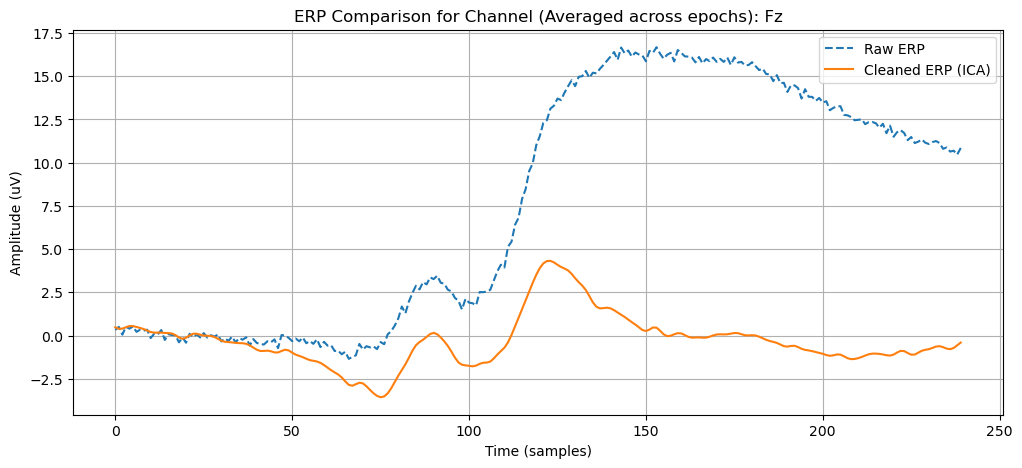

In [56]:
plot_erp_comparison(cleaned_epochs, raw_epochs, channel_idx=eeg_channels.index('Fz'), label='Fz')

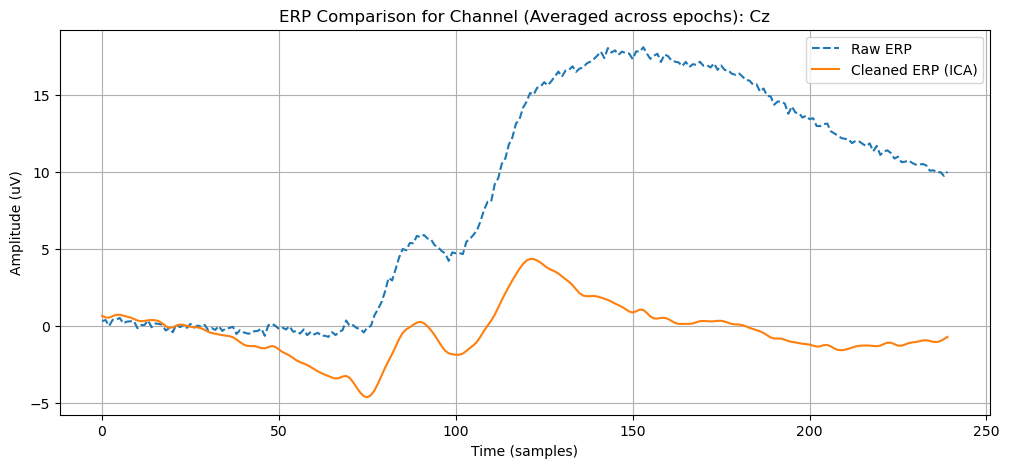

In [59]:
plot_erp_comparison(cleaned_epochs, raw_epochs, channel_idx=eeg_channels.index('Cz'), label='Cz')

### Here Fp1 and Fp2 for EOG (eyes area)

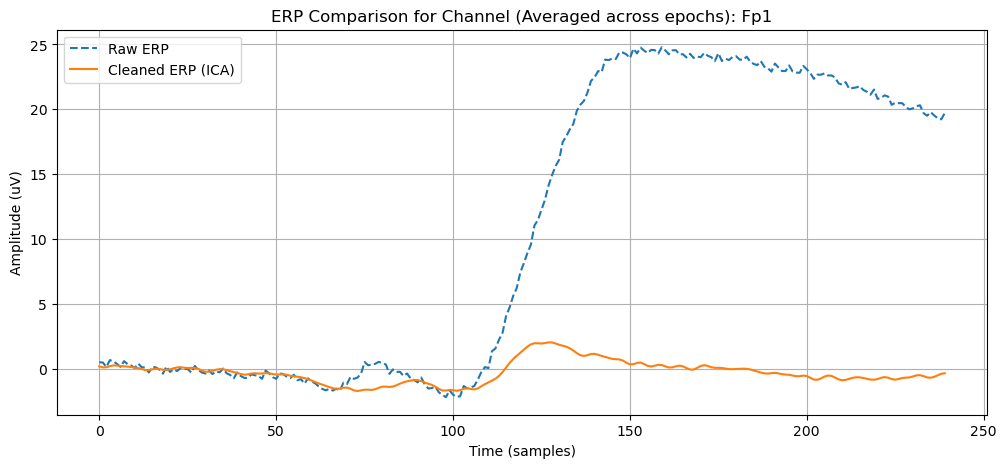

In [58]:
plot_erp_comparison(cleaned_epochs, raw_epochs, channel_idx=eeg_channels.index('Fp1'), label='Fp1')

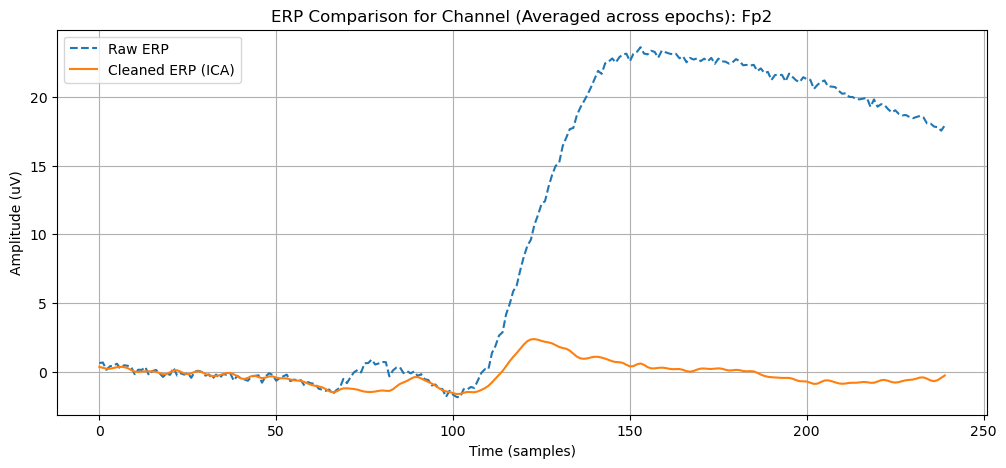

In [57]:
plot_erp_comparison(cleaned_epochs, raw_epochs, channel_idx=eeg_channels.index('Fp2'), label='Fp2')